In [7]:
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
import copy
import math
import matplotlib
from shutil import copyfile
from time import time
import pandas as pd
import numpy as np
from PIL import Image
from pathlib import Path
import random
import cv2
import shutil
import os
import gc
import glob
import json
import ast

In [3]:
import json
#with open('/content/WM811K_clean.json', 'r') as f:
#    data = json.load(f)

with open('WM811K_clean.json') as file:
          data = json.load(file)

In [9]:
import pandas as pd
db=pd.read_csv('Indici_immagini_difettose.csv')
db.head()

,Unnamed: 0,Indici
0,0,16176
1,1,16177
2,2,16178
3,3,16179
4,4,16180


In [10]:
cols = data['columns']
cols

['waferMap',
 'dieSize',
 'lotName',
 'waferIndex',
 'trainTestLabel',
 'failureType',
 'shape']

In [11]:
dict_ = dict()

for col in cols:
  dict_[col] = list()

for i in range(len(cols)):
  for j in range(len(data['data'])):
    if i == 6:
      dict_[cols[i]].append(tuple(data['data'][j][i]))
    elif i == 5:
      dict_[cols[i]].append(np.array(data['data'][j][i]))
    else:
      dict_[cols[i]].append(data['data'][j][i])

In [12]:
data = pd.DataFrame(dict_)
data.head()

,waferMap,dieSize,lotName,waferIndex,trainTestLabel,failureType,shape
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,Training,none,"(45, 48)"
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,Training,none,"(45, 48)"
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,Training,none,"(45, 48)"
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,Training,none,"(45, 48)"
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,Training,none,"(45, 48)"


In [13]:
data.drop(['dieSize', 'lotName', 'waferIndex', 'trainTestLabel', 'shape'], axis = 1, inplace = True)
data.head()

,waferMap,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",none
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",none
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",none
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",none
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",none


In [14]:
failure_types = ["Center", "Donut", "Edge-Loc", "Edge-Ring", "Loc", "Near-full", "Random", "Scratch", "none"]

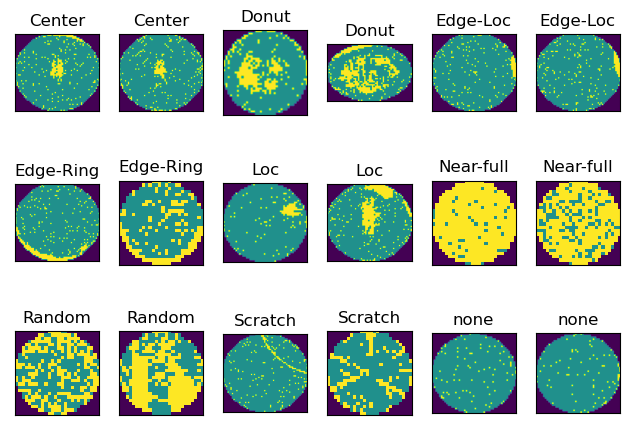

In [15]:
for i in range(len(failure_types)):
  b = 0
  for j in [0,1]:
    if i != 0:
      b=1
    plt.subplot(3,6,(2*i+1)+j)
    plt.imshow(data['waferMap'][data['failureType'] == failure_types[i]].iloc[j])
    plt.title(failure_types[i])
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()

In [16]:
classes = ["Center", "Donut", "Edge-Loc", "Edge-Ring", "Loc", "Near-full", "Random", "Scratch", "none"]
training = [0] * 9
test = [0] * 9

for i in range(9):
  training[i] = data[data['failureType'] == classes[i]]
  test[i] = training[i].sample(frac = 0.2)
  training[i] = training[i].drop(test[i].index)

In [17]:
print(sum(len(i) for i in training))
print(sum(len(i) for i in test))

136196
34050


In [18]:
training[0].head()

,waferMap,failureType
43,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Center
47,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Center
543,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2, 1,...",Center
645,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 1,...",Center
783,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 2,...",Center


In [19]:
classes = failure_types

for i in range(len(training)):
  print(classes[i])
  print(len(training[i]))
  print(len(test[i]))

Center
3423
856
Donut
444
111
Edge-Loc
4034
1008
Edge-Ring
7728
1932
Loc
2811
703
Near-full
119
30
Random
688
172
Scratch
927
232
none
116022
29006


In [21]:
for i in range(len(training)):
  training[i] =  training[i].reset_index(drop = True)
  test[i] =  test[i].reset_index(drop = True)

In [23]:
def apply_padding(a):
  dim1, dim2 = a.shape
  pad11 = 0
  pad12 = 0
  pad21 = 0
  pad22 = 0
  if(dim1 < 53):
    pad11 = int((53 - dim1)/2)
    pad12 = 53 - dim1 - pad11
  if(dim2 < 52):
    pad21 = int((52 - dim2)/2)
    pad22 = 52 - dim2 - pad21
  if(dim1 > 53):
    pad11 = int((math.ceil(dim1/53) * 53 - dim1)/2)
    pad12 = math.ceil(dim1/53) * 53 - dim1 - pad11
  if(dim2 > 52):
    pad21 = int((math.ceil(dim2/52) * 52 - dim2)/2)
    pad22 = math.ceil(dim2/52) * 52 - dim2 - pad21

  return np.pad(a, ((pad11,pad12),(pad21,pad22)), 'constant', constant_values = ((0,0),(0,0)))

In [24]:
training_padded = copy.deepcopy(training)

for i in range(len(training_padded)):
  for j in range(len(training_padded[i]['waferMap'])):
    if (j % 500 == 0):
      print(i, j)
    training_padded[i]['waferMap'][j] = np.array(training_padded[i]['waferMap'][j])
    training_padded[i]['waferMap'][j] = apply_padding(training_padded[i]['waferMap'][j])

0 0
0 500
0 1000
0 1500
0 2000
0 2500
0 3000
1 0
2 0
2 500
2 1000
2 1500
2 2000
2 2500
2 3000
2 3500
2 4000
3 0
3 500
3 1000
3 1500
3 2000
3 2500
3 3000
3 3500
3 4000
3 4500
3 5000
3 5500
3 6000
3 6500
3 7000
3 7500
4 0
4 500
4 1000
4 1500
4 2000
4 2500
5 0
6 0
6 500
7 0
7 500
8 0
8 500
8 1000
8 1500
8 2000
8 2500
8 3000
8 3500
8 4000
8 4500
8 5000
8 5500
8 6000
8 6500
8 7000
8 7500
8 8000
8 8500
8 9000
8 9500
8 10000
8 10500
8 11000
8 11500
8 12000
8 12500
8 13000
8 13500
8 14000
8 14500
8 15000
8 15500
8 16000
8 16500
8 17000
8 17500
8 18000
8 18500
8 19000
8 19500
8 20000
8 20500
8 21000
8 21500
8 22000
8 22500
8 23000
8 23500
8 24000
8 24500
8 25000
8 25500
8 26000
8 26500
8 27000
8 27500
8 28000
8 28500
8 29000
8 29500
8 30000
8 30500
8 31000
8 31500
8 32000
8 32500
8 33000
8 33500
8 34000
8 34500
8 35000
8 35500
8 36000
8 36500
8 37000
8 37500
8 38000
8 38500
8 39000
8 39500
8 40000
8 40500
8 41000
8 41500
8 42000
8 42500
8 43000
8 43500
8 44000
8 44500
8 45000
8 45500
8 46000
8 

In [25]:
test_padded = copy.deepcopy(test)

for i in range(len(test_padded)):
  for j in range(len(test_padded[i]['waferMap'])):
    if (j % 500 == 0):
      print(i, j)
    test_padded[i]['waferMap'][j] = np.array(test_padded[i]['waferMap'][j])
    test_padded[i]['waferMap'][j] = apply_padding(test_padded[i]['waferMap'][j])

0 0
0 500
1 0
2 0
2 500
2 1000
3 0
3 500
3 1000
3 1500
4 0
4 500
5 0
6 0
7 0
8 0
8 500
8 1000
8 1500
8 2000
8 2500
8 3000
8 3500
8 4000
8 4500
8 5000
8 5500
8 6000
8 6500
8 7000
8 7500
8 8000
8 8500
8 9000
8 9500
8 10000
8 10500
8 11000
8 11500
8 12000
8 12500
8 13000
8 13500
8 14000
8 14500
8 15000
8 15500
8 16000
8 16500
8 17000
8 17500
8 18000
8 18500
8 19000
8 19500
8 20000
8 20500
8 21000
8 21500
8 22000
8 22500
8 23000
8 23500
8 24000
8 24500
8 25000
8 25500
8 26000
8 26500
8 27000
8 27500
8 28000
8 28500
8 29000


In [33]:
training_padded_resize = copy.deepcopy(training_padded)

resize_model = keras.Sequential(keras.layers.Resizing(53, 52, interpolation = 'nearest'))

for i in range(len(training_padded_resize)):
  for j in range(len(training_padded_resize[i])):
    if(j % 500 == 0):
      print(i, j)
    img = tf.constant([training_padded_resize[i]['waferMap'][j]])
    img = tf.constant(np.moveaxis(img, 0, -1))
    training_padded_resize[i]['waferMap'][j] = (np.array(tf.squeeze(resize_model(img)))).astype(int)

0 0
0 500
0 1000
0 1500
0 2000
0 2500
0 3000
1 0
2 0
2 500
2 1000
2 1500
2 2000
2 2500
2 3000
2 3500
2 4000
3 0
3 500
3 1000
3 1500
3 2000
3 2500
3 3000
3 3500
3 4000
3 4500
3 5000
3 5500
3 6000
3 6500
3 7000
3 7500
4 0
4 500
4 1000
4 1500
4 2000
4 2500
5 0
6 0
6 500
7 0
7 500
8 0
8 500
8 1000
8 1500
8 2000
8 2500
8 3000
8 3500
8 4000
8 4500
8 5000
8 5500
8 6000
8 6500
8 7000
8 7500
8 8000
8 8500
8 9000
8 9500
8 10000
8 10500
8 11000
8 11500
8 12000
8 12500
8 13000
8 13500
8 14000
8 14500
8 15000
8 15500
8 16000
8 16500
8 17000
8 17500
8 18000
8 18500
8 19000
8 19500
8 20000
8 20500
8 21000
8 21500
8 22000
8 22500
8 23000
8 23500
8 24000
8 24500
8 25000
8 25500
8 26000
8 26500
8 27000
8 27500
8 28000
8 28500
8 29000
8 29500
8 30000
8 30500
8 31000
8 31500
8 32000
8 32500
8 33000
8 33500
8 34000
8 34500
8 35000
8 35500
8 36000
8 36500
8 37000
8 37500
8 38000
8 38500
8 39000
8 39500
8 40000
8 40500
8 41000
8 41500
8 42000
8 42500
8 43000
8 43500
8 44000
8 44500
8 45000
8 45500
8 46000
8 

In [34]:
for i in range(9):
  print(np.unique(list(map(lambda x: x.shape, training_padded_resize[i]['waferMap']))))

[52 53]
[52 53]
[52 53]
[52 53]
[52 53]
[52 53]
[52 53]
[52 53]
[52 53]


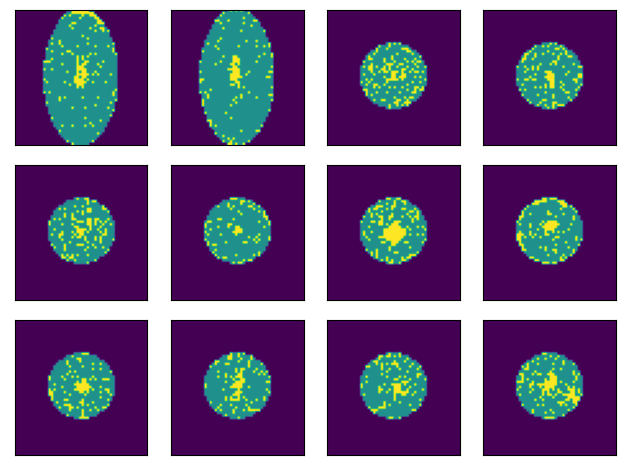

In [36]:
for i in range(12):
  plt.subplot(3,4,i+1)
  plt.imshow(training_padded_resize[0]['waferMap'][i])
  plt.xticks([])
  plt.yticks([])

plt.tight_layout()

In [37]:
for i in range(9):
  for j in range(len(training_padded_resize[i]['waferMap'])):
    correct_pixel = sum(
        list(
            map(
                lambda x: list(x).count(0)+list(x).count(1)+list(x).count(2), 
                training_padded_resize[i]['waferMap'][j]
                )
            )
        )
    if(correct_pixel != 53 * 52):
      print('Ops', i, j)
      break
print('OK')

OK


In [38]:
training_preprocessed = pd.concat([training_padded_resize[0],training_padded_resize[1],training_padded_resize[2],
                        training_padded_resize[3],training_padded_resize[4],training_padded_resize[5],
                        training_padded_resize[6],training_padded_resize[7],training_padded_resize[8]])
del training_padded_resize

training_preprocessed['failureType'] = list(map(lambda x: str(x), training_preprocessed['failureType']))

parsed = json.loads(training_preprocessed.to_json(orient = "split"))
del training_preprocessed

with open('WM811K_train_padded_resized_not_augmented.json','w') as f:
    json.dump(parsed, f)
del parsed

In [39]:
test_padded_resize = copy.deepcopy(test_padded)

resize_model = keras.Sequential(keras.layers.Resizing(53, 52, interpolation = 'nearest'))

for i in range(len(test_padded_resize)):
  for j in range(len(test_padded_resize[i])):
    if(j % 500 == 0):
      print(i, j)
    img = tf.constant([test_padded_resize[i]['waferMap'][j]])
    img = tf.constant(np.moveaxis(img, 0, -1))
    test_padded_resize[i]['waferMap'][j] = (np.array(tf.squeeze(resize_model(img)))).astype(int)

0 0
0 500
1 0
2 0
2 500
2 1000
3 0
3 500
3 1000
3 1500
4 0
4 500
5 0
6 0
7 0
8 0
8 500
8 1000
8 1500
8 2000
8 2500
8 3000
8 3500
8 4000
8 4500
8 5000
8 5500
8 6000
8 6500
8 7000
8 7500
8 8000
8 8500
8 9000
8 9500
8 10000
8 10500
8 11000
8 11500
8 12000
8 12500
8 13000
8 13500
8 14000
8 14500
8 15000
8 15500
8 16000
8 16500
8 17000
8 17500
8 18000
8 18500
8 19000
8 19500
8 20000
8 20500
8 21000
8 21500
8 22000
8 22500
8 23000
8 23500
8 24000
8 24500
8 25000
8 25500
8 26000
8 26500
8 27000
8 27500
8 28000
8 28500
8 29000


In [40]:
for i in range(9):
  print(np.unique(list(map(lambda x: x.shape, test_padded_resize[i]['waferMap']))))

[52 53]
[52 53]
[52 53]
[52 53]
[52 53]
[52 53]
[52 53]
[52 53]
[52 53]


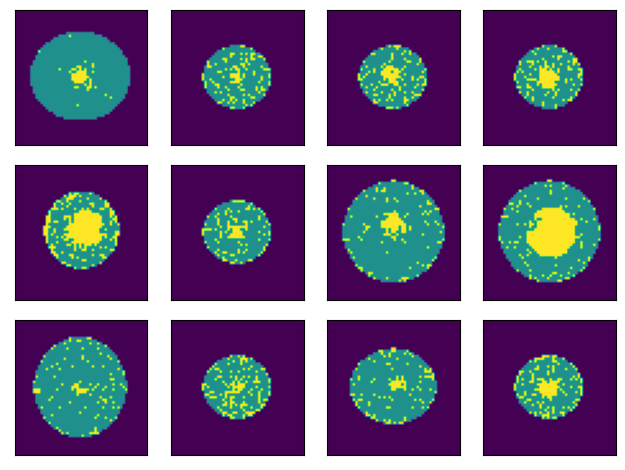

In [41]:
for i in range(12):
  plt.subplot(3,4,i+1)
  plt.imshow(test_padded_resize[0]['waferMap'][i])
  plt.xticks([])
  plt.yticks([])

plt.tight_layout()

In [42]:
for i in range(9):
  for j in range(len(test_padded_resize[i]['waferMap'])):
    correct_pixel = sum(
        list(
            map(
                lambda x: list(x).count(0)+list(x).count(1)+list(x).count(2), 
                test_padded_resize[i]['waferMap'][j]
                )
            )
        )
    if(correct_pixel != 53 * 52):
      print('Ops', i, j)
      break
print('OK')

OK


In [43]:
test_preprocessed = pd.concat([test_padded_resize[0],test_padded_resize[1],test_padded_resize[2],
                        test_padded_resize[3],test_padded_resize[4],test_padded_resize[5],
                        test_padded_resize[6],test_padded_resize[7],test_padded_resize[8]])
del test_padded_resize

test_preprocessed['failureType'] = list(map(lambda x: str(x), test_preprocessed['failureType']))

parsed = json.loads(test_preprocessed.to_json(orient = "split"))
del test_preprocessed

with open('WM811K_test_padded_resized_not_augmented.json','w') as f:
    json.dump(parsed, f)
del parsed